# PROYECTO 3 - BD2

#### Integrantes:
- Yosward García Tellez
- Leonardo Mora Chacón
- Yurgen Cambronero Mora

## Librerias

Aquí se realizan los respectivos imports de las blibliotecas a usar para el desarrollo de este proyecto

In [34]:
# Bilbiotecas a usar
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import trim, lower, regexp_replace, to_date, dayofweek,concat,col, lit, when, desc
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType

## Creación de la sesión de spark

### Descripción
En esta función crea una sesión de SPark utilizando la la biblioteca de SparkSession.
Es importante mencionar que para que el programa funcione como está escrito, el el driver de postgresql debe encontrarse en la misma carpeta que el libro de Jupyter.
Si se tuviese en otra carpeta, colocar la ruta a el .jar en el .config

#### Salida
- Retorna la sesion creada de Spark

In [35]:
# Esta funcion crea una sesion de spark
# y retorna la sesion creada
def create_spark_session():
    # El postgresql-42.6.0.jar es un driver de postgresql y debe estar en la misma carpeta que este archivo
    # En caso de estar en otra carpeta, modificar la ruta
    spark = SparkSession \
      .builder \
      .appName("Proyecto3") \
      .config("spark.driver.extraClassPath", "postgresql-42.6.0.jar") \
      .config("spark.executor.extraClassPath", "postgresql-42.6.0.jar") \
      .getOrCreate()
    return spark

# Llamada a la funcion para crear la sesion de spark
spark = create_spark_session()

## Lectura de Datos del OIJ
Aquí se procede a usar el método read de la sesión que fue creada. A su vez, usamos el método *.csv()* el cual nos indicará que el archivo a leer es de tipo *.csv*.
Además indicamos que dicho archivo tendrá los separadores como **';'**
- `header`: nos permitirá idnicar que use la primera fila del csv como los nombres de las columnas.
- `inferSchema`: hará que spark infiera el tipo y esquema de cada columna

In [36]:
#Lectura de datos
df_oij = spark.read.csv("Estadisticas.csv", sep=';', header=True, inferSchema=True)
df_oij.show()

+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|Delito|  SubDelito|    Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|     Distrito|
+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|28/1/2011|15:00:00 - 17:59:59|    PERSONA|MENOR DE EDAD [PE...|Menor de edad|HOMBRE|  COSTA RICA|PUNTARENAS|BUENOS AIRES| BUENOS AIRES|
|ASALTO|ARMA BLANCA| 8/2/2011|18:00:00 - 20:59:59|    PERSONA|CLIENTE LOCAL COM...|Mayor de edad|HOMBRE|  COSTA RICA|   HEREDIA|     HEREDIA|SAN FRANCISCO|
|ASALTO|ARMA BLANCA| 2/7/2011|18:00:00 - 20:59:59|EDIFICACION|TIENDA/BOUTIQUE [...|Mayor de edad| MUJER|  COSTA RICA|  ALAJUELA|  SAN CARLOS|      POCOSOL|
|ASALTO|ARMA BLANCA| 6/1/2011|21:00:00 - 23:59:59|    PERSONA|  

## Lectura de Datos del INEC

Ya que el archivo es un .xls, para facilitar el proceso de lectura se convierte el archivo excel a un .csv.

Una vez generado el .csv se realiza la lectura de los datos.

Importante mencionar que para la lectura del archivo excel es necesario indicar las columnas de los datos.

In [37]:
# Definicion de columnas
column_names = ['Provincia, canton y distrito', 'Población de 15 años y más', 'Tasa neta de participación',
                          'Tasa_de_ocupacion', 'Tasa de desempleo abierto', 'Porcentaje de población económicamente inactiva',
                          'Relación de dependencia económica', 'Sector Primario', 'Sector Secundario', 'Sector Terciario']
#Lectura archivo excel
file_inec_excel = pd.read_excel(io="reempleocenso2011-22.xls_2.xls", skiprows=9, header=None, names=column_names, usecols='B:K')

# Convertir archivo excel a csv
csv_inec = file_inec_excel.to_csv('reempleocenso2011-22.csv', index=False, encoding="UTF-8")

# Lectura de archivo csv
df_inec = spark.read.csv("reempleocenso2011-22.csv",header=True, inferSchema=True)

df_inec.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+
|Provincia, canton y distrito|Población de 15 años y más|Tasa neta de participación| Tasa_de_ocupacion|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+
|                        NULL|                      NULL|                      NULL|              NULL|                     NULL|                                           NULL|                

## Función para eliminar filas en NULL
### Descripción:
Función encargada de eliminar aquellas filas en donde es NULL para todas las columnas del Dataframe
#### Entrada:
- `df`: Dataframe al cual se le van a eliminar las filas en NULL.
#### Salida:
- El dataframe sin las filas en NULL

In [38]:
#Eliminar registros donde todas las columnas estan en NULL
def remove_null_rows(df):
    # Uso de la funcion na.drop para eliminar registros
    df = df.na.drop("all") # "all" para eliminar registros donde todas las columnas estan en NULL
    return df

In [39]:
# Aplicación de la función para el Dataframe del INEC
df_inec = remove_null_rows(df_inec)
df_inec.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+
|Provincia, canton y distrito|Población de 15 años y más|Tasa neta de participación| Tasa_de_ocupacion|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+
|                    San José|                 1087315.0|         56.02369138658071|54.076325627807954|       3.4759683101481724|                               43.9763086134193|               1

In [40]:
# Aplicación de la función para el Dataframe del OIJ
df_oij = remove_null_rows(df_oij)
df_oij.show()

+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|Delito|  SubDelito|    Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|     Distrito|
+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|28/1/2011|15:00:00 - 17:59:59|    PERSONA|MENOR DE EDAD [PE...|Menor de edad|HOMBRE|  COSTA RICA|PUNTARENAS|BUENOS AIRES| BUENOS AIRES|
|ASALTO|ARMA BLANCA| 8/2/2011|18:00:00 - 20:59:59|    PERSONA|CLIENTE LOCAL COM...|Mayor de edad|HOMBRE|  COSTA RICA|   HEREDIA|     HEREDIA|SAN FRANCISCO|
|ASALTO|ARMA BLANCA| 2/7/2011|18:00:00 - 20:59:59|EDIFICACION|TIENDA/BOUTIQUE [...|Mayor de edad| MUJER|  COSTA RICA|  ALAJUELA|  SAN CARLOS|      POCOSOL|
|ASALTO|ARMA BLANCA| 6/1/2011|21:00:00 - 23:59:59|    PERSONA|  

## Función para separar Provincia, canton y distrito

### Descripción:
Esta función se encarga de recorrer los datos del INEC y determinar que filas hacen referencia a una provincia, un canton o un distrito.

La función convierte cada fila de los datos en una tupla y las procesa.
Para determinar que tipo de ubicación son se usa como referencia si el nombre de la ubicación cuenta con espacios vacios a la derecha o según los valores en la columna de "Población de 15 años y más"

#### Entrada:
- `df`: Dataframe al cual se le va a realizar el procesamiento
#### Salida:
- Una lista de tuplas para cada una de las filas con las provincia, canton y distrito acomodado
- Dataframe que nos ayudará a la reconstrucción del dataframe

In [41]:
# Funcion para procesar los datos del dataframe del INEC
# y separar porvincia, distrito y canton
def proccess_inec(df):
    # Listado de provincias en Costa Rica
    list_province = ['Alajuela', 'Cartago', 'Guanacaste', 'Heredia', 'Limón', 'Puntarenas', 'San José']
    # Diccionario para determinar si ya visitamos la provincia
    province_counts = {province: 0 for province in list_province}
    current_province = None
    current_canton = None
    current_district = None
    # Agregar columna con el string sin espacios
    df = df.withColumn('trimmed', trim(df['Provincia, canton y distrito']))

    # Contador de poblacion por distrito y canton
    dist_pob = 0
    canton_pob = 0
    # Funcion local para procesar cada fila del dataframe
    def process_row(row):
        # Indicamos que vamos a modificar las variables globales
        nonlocal current_province, current_canton, current_district, dist_pob, canton_pob
        # Si el valor en "Provincia, canton y distrito" es igual al valor en la columna "trimmed"
        if row[10] == row[0]:
            # Si la fila hace referencia a una provincia y si aún no hemos visitado la provincia
            if row[0] in list_province and province_counts[row[0]] == 0:
                # Es provincia
                current_province = row[0] # Actualizamos la provincia actual
                province_counts[current_province] += 1 # Indicamos que ya visitamos la provincia
                return 
            else:
                # Verifimmos si llegamos al ltimo distrito de un canton
                if dist_pob + row[1] == canton_pob:
                    # Reiniciamos los contadores
                    canton_pob = 0
                    dist_pob = 0
                    current_district = row[0]
                    # Devolvemos una tupla con la provincia actual y el canton-distrito
                    return (current_province, f'{current_canton}-{current_district}')
                elif dist_pob + row[1] < canton_pob: # Si aun faltan distritos por visitar
                    current_district = row[0] # Actualizamos el distrito actual
                    dist_pob += row[1] # Sumamos la poblacion del contador de poblacion para los distritos
                    return (current_province, f'{current_canton}-{current_district}')
                else:
                    # Es un canton
                    current_canton = row[0]
                    canton_pob += row[1] # Sumamos la poblacion del contador de poblacion para los cantones
                    return
        else:
            # Si la fila en "Provincia, canton y distrito" no tiene espacios vacios
            # Verificamos si llegamos al ultimo distrito de un canton
            if dist_pob + row[1] == canton_pob:
                canton_pob = 0
                dist_pob = 0
                current_district = row[0]
                # Devolvemos una tupla con la provincia actual y el canton-distrito
                return (current_province, f'{current_canton}-{current_district}')
            # Si aun faltan distritos por visitar
            current_district = row[0]
            dist_pob += row[1]
            return (current_province, f'{current_canton}-{current_district}')

    list_tuples = []
    # Iteramos sobre cada fila del dataframe
    for row in df.collect():
        row_tuple = tuple(row) # Convertimos la fila a una tupla
        actual_tuple = process_row(row_tuple)
        # Si la funcion process_row retorna una tupla
        if actual_tuple:
            list_tuples.append(row_tuple + actual_tuple)
    return list_tuples, df

list_tuples, prube_df = proccess_inec(df_inec)
# Crear esquema para el dataframe a crear
schema = StructType(prube_df.schema.fields + [StructField("Provincia", StringType(), True),StructField("Canton-Distrito", StringType(), True)])

#crear dataframe usando el esquema y la lista de tuplas
df_inec = spark.createDataFrame(list_tuples, schema=schema)
df_inec = df_inec.drop("trimmed") # Eliminamos la columna "trimmed"
df_inec.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+---------+--------------------+
|Provincia, canton y distrito|Población de 15 años y más|Tasa neta de participación| Tasa_de_ocupacion|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|Provincia|     Canton-Distrito|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+---------+--------------------+
|           Carmen           |                    2431.0|         56.31427396133278|54.7922665569724

## Función para eliminar espacios en blancos

### Descripción:
Esta función se encarga de eliminar los espacios que se encuentren a ambos lados del valor que se encuentre en la columna seleccionada por el usuario.

#### Entrada:
- `df`: dataframe al cual se le quiere hacer la modificación
- `column`: columna a la cual se le va a eliminar los espacios

#### Salida:
- El dataframe modificado sin los espacios en los extremos para la columna seleccionada

In [42]:
#Funcion para eliminar espacios en blancos en una columna especifica
#Hace uso de la funcion trim()
def remove_blank_spaces(df, column):
    df = df.withColumn(column, trim(df[column]))
    return df

In [43]:
# Eliminacionde espacios en blanco en el dataframe del OIJ
df_oij = remove_blank_spaces(df_oij, "Distrito")
df_oij = remove_blank_spaces(df_oij, "Canton")
df_oij = remove_blank_spaces(df_oij, "Provincia")
df_oij.show()

+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|Delito|  SubDelito|    Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|     Distrito|
+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|28/1/2011|15:00:00 - 17:59:59|    PERSONA|MENOR DE EDAD [PE...|Menor de edad|HOMBRE|  COSTA RICA|PUNTARENAS|BUENOS AIRES| BUENOS AIRES|
|ASALTO|ARMA BLANCA| 8/2/2011|18:00:00 - 20:59:59|    PERSONA|CLIENTE LOCAL COM...|Mayor de edad|HOMBRE|  COSTA RICA|   HEREDIA|     HEREDIA|SAN FRANCISCO|
|ASALTO|ARMA BLANCA| 2/7/2011|18:00:00 - 20:59:59|EDIFICACION|TIENDA/BOUTIQUE [...|Mayor de edad| MUJER|  COSTA RICA|  ALAJUELA|  SAN CARLOS|      POCOSOL|
|ASALTO|ARMA BLANCA| 6/1/2011|21:00:00 - 23:59:59|    PERSONA|  

In [44]:
# Eliminacion de espacios en blanco en el dataframe del INEC
df_inec = remove_blank_spaces(df_inec, "Provincia, canton y distrito")
df_inec = remove_blank_spaces(df_inec, "Provincia")
df_inec = remove_blank_spaces(df_inec, "Canton-Distrito")
df_inec.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+---------+--------------------+
|Provincia, canton y distrito|Población de 15 años y más|Tasa neta de participación| Tasa_de_ocupacion|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|Provincia|     Canton-Distrito|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+---------+--------------------+
|                      Carmen|                    2431.0|         56.31427396133278|54.7922665569724

## Función para colocar letras en minúsculas

### Descripción:
Esta función coloca todos las letras en minúsculas para una columna seleccionada
#### Entradas:
- `df`: Dataframe a modificar con la función
- `column`: Nombre de la columna a modificar
#### Salida:
- Dataframe modificado con letras en minúsculas para la columna indicada

In [45]:
# Función para convertir una columna a minusculas
# Uso de la funcion lower()
def set_lower_case(df, column):
    df = df.withColumn(column, lower(df[column]))
    return df

In [46]:
# Convertir a minusculas el dataframe del INEC
df_oij = set_lower_case(df_oij, "Distrito")
df_oij = set_lower_case(df_oij, "Canton")
df_oij = set_lower_case(df_oij, "Provincia")
df_oij.show()

+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|Delito|  SubDelito|    Fecha|               Hora|    Victima|          SubVictima|         Edad|Genero|Nacionalidad| Provincia|      Canton|     Distrito|
+------+-----------+---------+-------------------+-----------+--------------------+-------------+------+------------+----------+------------+-------------+
|ASALTO|ARMA BLANCA|28/1/2011|15:00:00 - 17:59:59|    PERSONA|MENOR DE EDAD [PE...|Menor de edad|HOMBRE|  COSTA RICA|puntarenas|buenos aires| buenos aires|
|ASALTO|ARMA BLANCA| 8/2/2011|18:00:00 - 20:59:59|    PERSONA|CLIENTE LOCAL COM...|Mayor de edad|HOMBRE|  COSTA RICA|   heredia|     heredia|san francisco|
|ASALTO|ARMA BLANCA| 2/7/2011|18:00:00 - 20:59:59|EDIFICACION|TIENDA/BOUTIQUE [...|Mayor de edad| MUJER|  COSTA RICA|  alajuela|  san carlos|      pocosol|
|ASALTO|ARMA BLANCA| 6/1/2011|21:00:00 - 23:59:59|    PERSONA|  

In [47]:
# Convertir a minusculas el dataframe del OIJ
df_inec = set_lower_case(df_inec, "Provincia, canton y distrito")
df_inec = set_lower_case(df_inec, "Provincia")
df_inec = set_lower_case(df_inec, "Canton-Distrito")
df_inec.show()

+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+---------+--------------------+
|Provincia, canton y distrito|Población de 15 años y más|Tasa neta de participación| Tasa_de_ocupacion|Tasa de desempleo abierto|Porcentaje de población económicamente inactiva|Relación de dependencia económica|    Sector Primario| Sector Secundario| Sector Terciario|Provincia|     Canton-Distrito|
+----------------------------+--------------------------+--------------------------+------------------+-------------------------+-----------------------------------------------+---------------------------------+-------------------+------------------+-----------------+---------+--------------------+
|                      carmen|                    2431.0|         56.31427396133278|54.7922665569724

## Función para eliminar caracteres especiales
### Descripción:
Esta función se encarga de recorrer el diccionario que contiene para cada caracter especial, la letra por la cual se va a sustituir en el dataframe. 

Se hace uso la función de *regexp_replace* para poder sustituir los caracteres especiales según el diccionario

Es importante mencionar que el **?** también se va a sustituir ya que en los archivos .csv en los espacios donde habian **ñ**, se colocaban el signo de interrogación.

#### Entradas:
* `df`: Dataframe a modificar
* `column`: Nombre de la columna del dataframe a modificar

#### Salidas:
* Dataframe modificado sin caracteres espciales en la columna seleccionada

In [48]:
# Función para remover datos espciales en una columna especifica
# Uso de la funcion regexp_replace()
def remove_special_characters(df, column):
    # Diccionario de caracteres especiales
    replacements = {
        'ñ': 'n',
        '\\?': 'n',
        'á': 'a',
        'é': 'e',
        'í': 'i',
        'ó': 'o',
        'ú': 'u'
    }
    for key, value in replacements.items():
        df = df.withColumn(column, regexp_replace(df[column], key, value))
    return df

In [49]:
# Remover caracteres especiales en el dataframe del INEC
# para las columnas indicadas
df_inec = remove_special_characters(df_inec, "Provincia, canton y distrito")
df_inec = remove_special_characters(df_inec, "Canton-Distrito")
df_inec = remove_special_characters(df_inec, "Provincia")

In [50]:
# Remover caracetres especiales en el dataframe del OIJ
# para las columnas indicadas
df_oij = remove_special_characters(df_oij, "Distrito")
df_oij = remove_special_characters(df_oij, "Canton")
df_oij = remove_special_characters(df_oij, "Provincia")


## Función para listar distritos que no coincidan

### Descripción:
Esta función se encarga de crear una lista que contenga todos los distritos de los datos del OIJ que no se encuentran en los datos del INEC.

Debido los distritos de los datos del INEC están en la columna *Columna-Distrito*, al dataframe del OIJ se crea una columna adicional que concatene cada distrito con sus respectivos cantones separados por un guión (**-**). Con esto nos aseguramos que si se hagan las validaciones apropiadas y no haya confusión de dos distritos con el mismo nombre.

#### Entradas:
- `df_oij`: Dataframe de los datos del OIJ
- `df_inec`: Dataframe de los datos del INEC

#### Salida:
- Lista con todos los distritos (canton-distrito) de los datos del OIJ que no están en los datos del INEC

In [51]:
# Función para crear lista de distritos que se encuentran en el dataframe del OIJ
# y no en el dataframe del INEC
def non_matching_districts(df_oij, df_inec):
    # Creacion de una columna con el formato "Canton-Distrito" para el dataframe del OIJ
    df_oij = df_oij.withColumn("Canton-Distrito", concat(col("Canton"), lit("-"), col("Distrito")))
    # Obtenemos los distritos que se encuentran en el dataframe del OIJ sin repetición
    oij_districts = df_oij.select("Canton-Distrito").distinct()
    # Obtenemos los distritos que se encuentran en el dataframe del INEC sin repetición
    inec_districts = df_inec.select("Canton-Distrito").distinct()

    # Con el uso de .join() y el parametro "left_anti" obtenemos los distritos que se encuentran en el dataframe del OIJ
    # y no en el dataframe del INEC
    unmatched_district = (oij_districts \
                          .join(inec_districts, oij_districts["Canton-Distrito"] == inec_districts["Canton-Distrito"], "left_anti")\
                            .select("Canton-Distrito").distinct().collect())
    # Convertimos el resultado a una lista
    list_unmatched_district = [district["Canton-Distrito"] for district in unmatched_district]
    return list_unmatched_district

In [52]:
# Llamada a la funcion para obtener los distritos que se encuentran en el dataframe del OIJ
# y no en el dataframe del INEC
list_unmatched_districts = non_matching_districts(df_oij, df_inec)
print(list_unmatched_districts)

['leon cortes-desconocido', 'leon cortes-san antonio', 'leon cortes-santa cruz', 'orotina-mastate', 'golfito-jimenez', 'santa barbara-desconocido', 'san jose-desconocido', 'san rafael-los angeles', 'vasquez de coronado-desconocido', 'desamparados-desconocido', 'cartago-guadalupe', 'vasquez de coronado-cascajal', 'moravia-desconocido', 'naranjo-desconocido', 'sarapiqui-horquetas', 'alajuela-la garita', 'vasquez de coronado-san rafael', 'quepos-quepos', 'siquirres-cairo', 'goicoechea-mata platano', 'upala-san jose (pizote)', 'santo domingo-desconocido', 'vasquez de coronado-dulce nombre de jesus', 'bagaces-fortuna', 'la union-desconocido', 'nandayure-desconocido', 'vasquez de coronado-san isidro', 'talamanca-desconocido', 'cartago-san francisco', 'zarcero-tapezco', 'escazu-desconocido', 'abangares-desconocido', 'curridabat-desconocido', 'tibas-desconocido', 'quepos-savegre', 'san carlos-tigra', 'san ramon-desconocido', 'osa-cortes', 'coto brus-agua buena', 'aserri-monterry', 'el guarco-d

## Función para contabilizar la cantidad de registros sin coincidencia entre los dataframes

### Descripción:
Esta función de contar el número de registros que hay en los datos del OIJ que no coinciden con ninguno de los distritos de los datos del INEC.

Debido los distritos de los datos del INEC están en la columna *Columna-Distrito*, al dataframe del OIJ se crea una columna adicional que concatene cada distrito con sus respectivos cantones separados por un guión (**-**). Con esto nos aseguramos que si se hagan las validaciones apropiadas y no haya confusión de dos distritos con el mismo nombre.

#### Entradas:
- `df_oij`: Dataframe de los datos del OIJ
- `df_inec`: Dataframe de los datos del INEC

#### Salida:
- El número de registros de los datos del OIJ que no coinciden con ninguno de los distritos de los datos del INEC


In [53]:
# Funcion para contabilizar los registros que se encuentran en el dataframe del OIJ
# pero no coinciden con los distritos del INEC
def count_mismatched(df_oij, df_inec):
    # Creacion de una columna con el formato "Canton-Distrito" para el dataframe del OIJ
    df_oij = df_oij.withColumn("Canton-Distrito", concat(col("Canton"), lit("-"), col("Distrito")))
    # Se obtienen los registros de distritos que se encuentran en el dataframe del OIJ
    oij_districts = df_oij.select("Canton-Distrito")
    # Se obtienen los registros de distritos que se encuentran en el dataframe del INEC
    inec_districts = df_inec.select("Canton-Distrito")

    # Con el uso de .join() y el parametro "left_anti" obtenemos los registros que se encuentran en el dataframe del OIJ
    # pero no en el dataframe del INEC
    # .count() para obtener el numero de registros
    count = oij_districts.join(inec_districts, oij_districts["Canton-Distrito"] == inec_districts["Canton-Distrito"], "left_anti")\
                            .select("Canton-Distrito").count()
    return count

# Llamada a la funcion
print("Numero de registros: ")
print(count_mismatched(df_oij, df_inec))

Numero de registros: 
3294


## Guardar Datos de Inec y OIJ en una BD en Postgres

### Configuración
Antes de proceder a realizar el guardado de los datos del INEC y del OIJ, se deben configurar la conexión a Postgresql

- Definición de variables:

In [54]:
# Cambiar datos según la configuracion de la base de datos
POSTGRESQL_URL = "jdbc:postgresql://localhost/proyecto3"
POSTGRESQL_USER = "postgres"
POSTGRESQL_PASSWORD = "root"

### Función para realizar el guardado:
Esta función se encarga de escribir los dataframes en una tabla en la base de datos de postgresql.

Usa la función write() que permite hacer el guardado, al igual de las configuraciones apropiadas que le indicara los datos de la conexión de la base de datos.

#### Entradas:
- `df`: Dataframe a guardar en la base de datos
- `table_name`: Nombre con la que guardar el dataframe

In [55]:
# Función para guardar dataframe en la base de datos
def save_spark_df_to_db(df, table_name):
    # Hace uso de la funcion .write.format("jdbc") para guardar el dataframe en la base de datos
    # Se necesitan el url de la base de datos, el usuario y la contraseña
    df \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", POSTGRESQL_URL) \
        .option("user", POSTGRESQL_USER) \
        .option("password", POSTGRESQL_PASSWORD) \
        .option("dbtable", table_name) \
        .save()

In [56]:
# Guardado de los dataframes
save_spark_df_to_db(df_inec, "inec")
save_spark_df_to_db(df_oij, "oij")

# Graficación de datos

### Funcion para comparar los crimenes con la ocupacion en los 10 distritos con mas criminalidad:

#### Descripción:
Esta función crea un gráfico el cual muestra los 10 distritos con mayor criminalidad y compara la cantidad de crimenes que han sucedido en esos distritos con la cantidad de personas que trabajan.

Para realizar esta funcion necesitamos crear una columna en el dataframe del oij para concatenar el canton con un - y el distrito, para que asi posea el mismo formato que la columna Canton-Distrito de el dataframe del inec.

Adicionalmente se hace un inner join de los datos a usar tanto del dataframe del inec como del oij usando como clave de unión las columnas de Canton-Distrito ya que ambos de estos dataframes comparten esas columnas.

#### Entradas:
- `df_oij`: Dataframe de los datos del OIJ
- `df_inec`: Dataframe de los datos del INEC

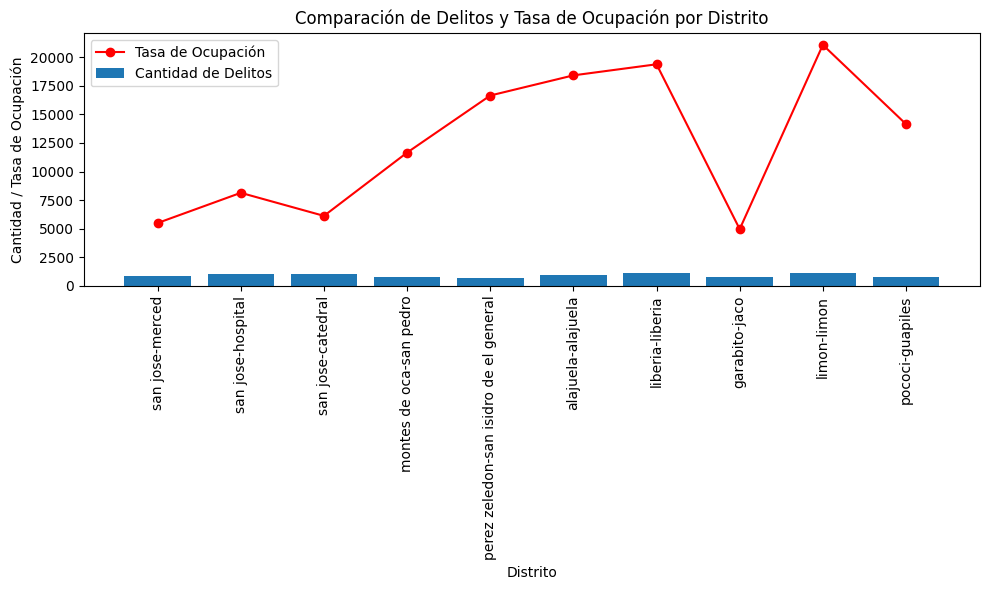

In [68]:
# Función para comparar grafico de ocupacion con crimenes en los 10 distritos con mas criminalidad
def compare_crimes_with_occupation_by_district(df_oij, df_inec):
    # Primero se añade la columna Canton-Distrito en el df del oij y se le da el valor para que coincida 
    # con el formato de la misma columna en el df del inec
    df_oij = df_oij.withColumn("Canton-Distrito", concat(col("Canton"), lit("-"), col("Distrito")))
    
    # Se cuentan los crimenes realizados en cada distrito y se almacenan los 10 con mas crimenes
    crimes_by_district = df_oij.groupBy("Canton-Distrito").count()
    districts_with_most_crimes = crimes_by_district.orderBy(desc("count")).limit(11)

    # Se obtienen los datos de el df inec a usar, siendo estos el canton-distrito, 
    # la tasa de ocupacion de ese distrito y la población de 15 años o mas registrada
    occupation_by_district = df_inec.select("Canton-Distrito", "Tasa_de_ocupacion", "Población de 15 años y más")

    # Se hace un inner join de los datos en un solo dataframe usando la columna Canton-Distrito como clave de union,
    # adicionalmente se convierte el dataframe a pandas para poder graficar
    resultados = districts_with_most_crimes.join(occupation_by_district, "Canton-Distrito", "inner")
    resultados_pandas = resultados.toPandas()

    # Se grafican los datos, se crea un grafico de barras para el df del oij y un grafico de lineas para los datos del inec
    plt.figure(figsize=(10, 6))
    plt.bar(resultados_pandas['Canton-Distrito'], resultados_pandas['count'], label='Cantidad de Delitos')
    plt.plot(resultados_pandas['Canton-Distrito'], resultados_pandas['Tasa_de_ocupacion'] / 100 * resultados_pandas['Población de 15 años y más'], marker='o', color='red', label='Tasa de Ocupación')
    plt.xlabel('Distrito')
    plt.ylabel('Cantidad / Tasa de Ocupación')
    plt.title('Comparación de Delitos y Tasa de Ocupación por Distrito')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Se llama a la funcion y se crea el gráfico
compare_crimes_with_occupation_by_district(df_oij, df_inec)


### Funcion para graficar los crimenes por dia de la semana del distrito con mas crimenes:

#### Descripción:
Esta función crea un gráfico el cual muestra la cantidad de crimenes realizados por dia de la semana del distrito con mas crimenes.

Para esto se utiliza la funcion filter para hacer un dataframe que posea solo los datos del distrito con mas crimenes, buscando este distrito en la columna Canton-Distrito.

Tambien se hace uso de la funcion map para cambiar los dias de la semana que estan almacenados de forma numerica a su nombre en texto.

#### Entradas:
- `df_oij`: Dataframe de los datos del OIJ

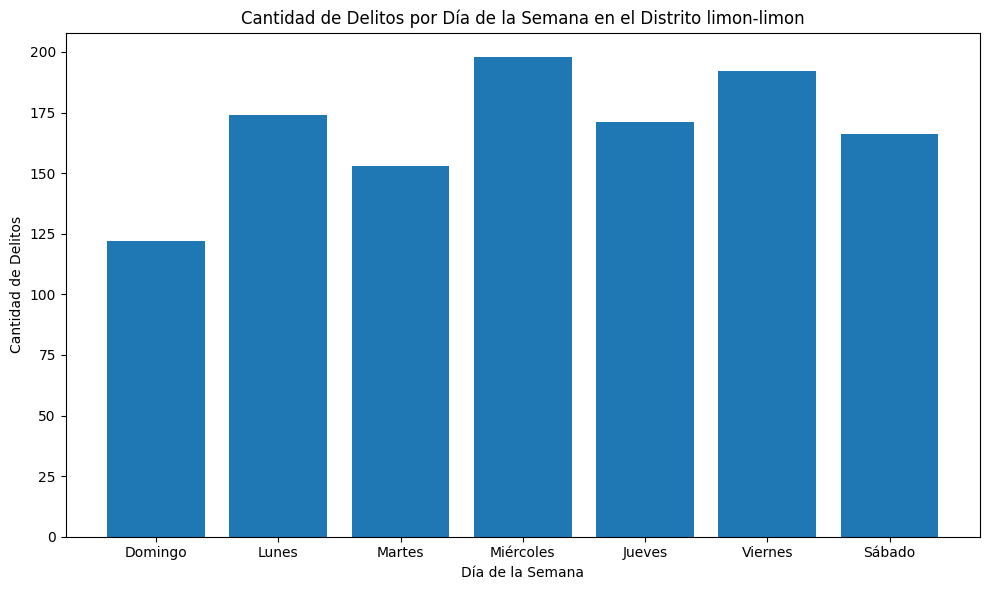

In [67]:
# Función para graficar los crimenes por dia de la semana del distrito con mas crimenes
def district_with_most_crimes_per_day(df_oij):
    # Se añade la columna Canton-Distrito en el df del oij para hacer buscqueda del distrito de forma precisa y se obtiene 
    # el nombre del distrito con mas crimenes
    df_oij = df_oij.withColumn("Canton-Distrito", concat(col("Canton"), lit("-"), col("Distrito")))
    district_with_most_crimes = df_oij.groupBy("Canton-Distrito").count().orderBy("count", ascending=False).first()["Canton-Distrito"]
    
    # Se crea el df del distrito con mas crimenes y se convierte la fecha
    df_district_with_most_crimes = df_oij.filter(df_oij["Canton-Distrito"] == district_with_most_crimes)
    df_district_with_most_crimes = df_district_with_most_crimes.withColumn("Fecha", to_date(df_district_with_most_crimes["Fecha"], "d/M/yyyy"))

    # Se crea la columna numero de dia de la semana y se obtiene el dia de la semana (usando la funcion dayofweek de pyspark)
    df_district_with_most_crimes = df_district_with_most_crimes.withColumn("DiaSemanaNum", dayofweek("Fecha"))

    # Se crea un diccionario para mapear los numeros del dia de la semana en el nombre del dia
    weekdays = {1: "Domingo", 2: "Lunes", 3: "Martes", 4: "Miércoles", 5: "Jueves", 6: "Viernes", 7: "Sábado"}

    # Se cuentan los crimenes hechos en base a los dias de los semana (para tener el valor de cuantos crimenes se hicieron Lunes por ejemplo)
    crimes_by_day_of_the_week = df_district_with_most_crimes.groupBy("DiaSemanaNum").count()

    # Se convierte el df a Pandas y luego se ordenan segun el numero del dia de la semana
    crimes_by_day_of_the_week_pandas = crimes_by_day_of_the_week.toPandas()
    crimes_by_day_of_the_week_pandas = crimes_by_day_of_the_week_pandas.sort_values(by="DiaSemanaNum")

    # Se grafica lo anterior y se mapean los dias de la semana de numeros a nombre del dia. (DiaSemanaNum es el eje X y la cantidad el eje Y)
    plt.figure(figsize=(10, 6))
    plt.bar(crimes_by_day_of_the_week_pandas['DiaSemanaNum'].map(weekdays), crimes_by_day_of_the_week_pandas['count'])
    plt.xlabel('Día de la Semana')
    plt.ylabel('Cantidad de Delitos')
    plt.title(f'Cantidad de Delitos por Día de la Semana en el Distrito {district_with_most_crimes}')
    plt.tight_layout()
    plt.show()

# Se llama a la funcion y se muestra el grafico
district_with_most_crimes_per_day(df_oij)


### Funcion para graficar los crimenes que se han cometido en un distrito especifico:

#### Descripción:
Esta función crea un gráfico el cual muestra los crimenes cometidos y la cantidad de veces que se cometio en un distrito especifico.

Para lo anterior se realiza un filter para almacenar en un nuevo dataframe el o los valores donde el distrito coincida con el distrito deseado.

#### Entradas:
- `district`: Nombre del distrito del cual queremos ver los datos
- `df_oij`: Dataframe de los datos del OIJ

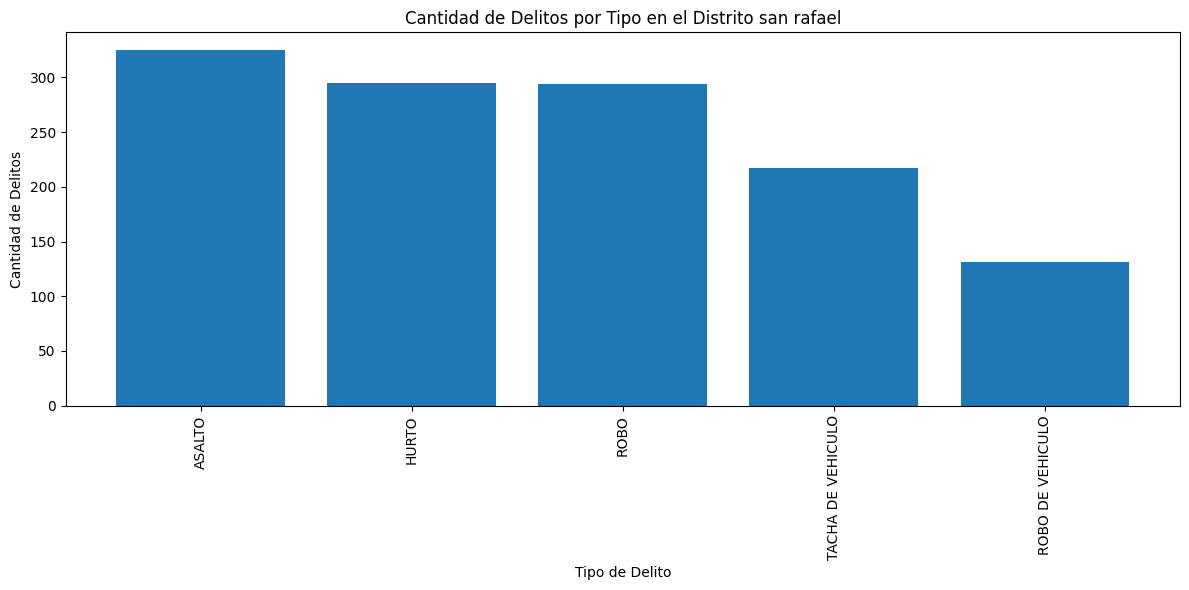

In [61]:
# Función para graficar crimenes hechos en un distrito dado
def graph_crime_by_district(district, df_oij):
    # Se hace el df del distrito seleccionado en base del df del oij
    df_selected_district = df_oij.filter(df_oij["Distrito"] == district)

    # Se obtiene la cuenta de los delitos hechos para cada tipo de delito y se convierte el df en Pandas
    crimes_by_type = df_selected_district.groupBy("Delito").count().orderBy("count", ascending=False)
    crimes_by_type_pandas = crimes_by_type.toPandas()

    # Se hace un grafico de barras de lo anterior usando el tipo de delito como eje X y la cuenta de ese delito como eje Y
    plt.figure(figsize=(12, 6))
    plt.bar(crimes_by_type_pandas['Delito'], crimes_by_type_pandas['count'])
    plt.xlabel('Tipo de Delito')
    plt.ylabel('Cantidad de Delitos')
    plt.title(f'Cantidad de Delitos por Tipo en el Distrito {district}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
# Se llama a la funcion y se muestra el grafico
graph_crime_by_district("san rafael", df_oij)


### Funcion para crear un grafico de los crimenes realizados por género:

#### Descripción:
Esta función crea un gráfico que muestra la cantidad de delitos realizados por cada género.

#### Entradas:
- `df_oij`: Dataframe de los datos del OIJ

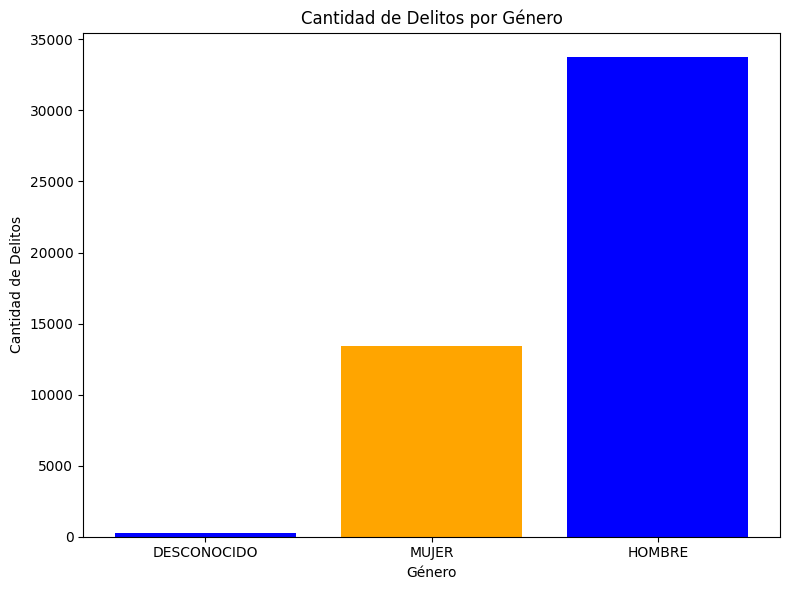

In [63]:
# Función para crear grafico de crimenes realizados por genero
def crimes_by_gender(df_oij):
    # Se genera el data frame de los crimenes hechos segun el genero y se pasa a Pandas
    crime_by_gender = df_oij.groupBy("Genero").count().orderBy("count")
    crime_by_gender_pandas = crime_by_gender.toPandas()

    # Se hace un grafico de barras de lo anterior, usando el Genero como eje X y la cantidad o cuenta del eje Y
    plt.figure(figsize=(8, 6))
    plt.bar(crime_by_gender_pandas['Genero'], crime_by_gender_pandas['count'], color=['blue', 'orange'])
    plt.xlabel('Género')
    plt.ylabel('Cantidad de Delitos')
    plt.title('Cantidad de Delitos por Género')
    plt.tight_layout()
    plt.show()
    
# Se llama a la funcion y se muestra el grafico
crimes_by_gender(df_oij)


### Funcion para crear un grafico de los crimenes realizados por edad:

#### Descripción:
Esta función crea un gráfico que muestra la cantidad de delitos realizados por rango de edad.

#### Entradas:
- `df_oij`: Dataframe de los datos del OIJ

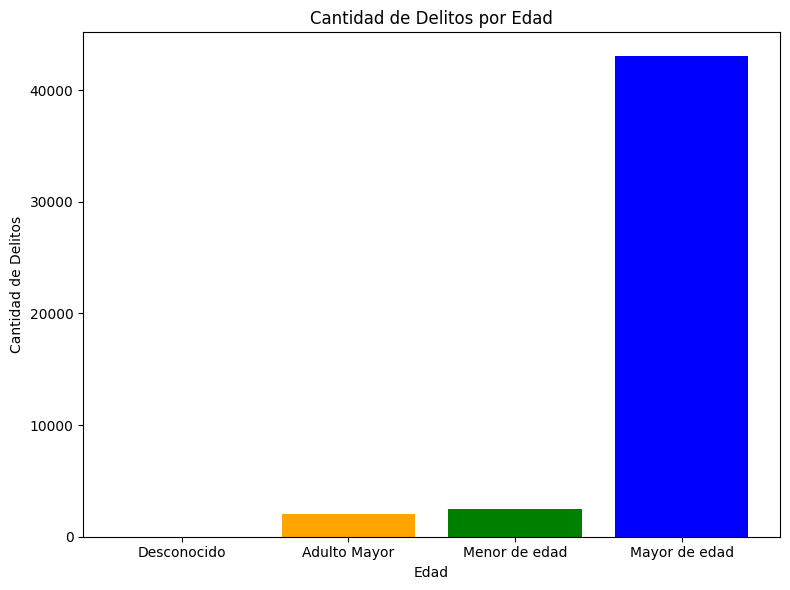

In [64]:
# Función para graficar la cantidad de crimenes hechos segun la edad
def crimes_by_age(df_oij):
    # Se crea el df con la cantidad de crimenes hechos segun la edad y se convierte a Pandas
    crime_by_age = df_oij.groupBy("Edad").count().orderBy("count")
    crime_by_age_pandas = crime_by_age.toPandas()

    # Se genera un grafico de barras con el eje X siendo la edad y la cantidad de crimenes hechos
    plt.figure(figsize=(8, 6))
    plt.bar(crime_by_age_pandas['Edad'], crime_by_age_pandas['count'], color=['blue', 'orange', 'green'])
    plt.xlabel('Edad')
    plt.ylabel('Cantidad de Delitos')
    plt.title('Cantidad de Delitos por Edad')
    plt.tight_layout()
    plt.show()

crimes_by_age(df_oij)

### Cerrar sesión de spark:
Para confirmar que hemos terminado de usar la sesión de spark, usamos el comando *stop()* para cerrarla.

In [32]:
# Cerrar la sesión de spark
spark.stop()